<a href="https://colab.research.google.com/github/khushboo0824/cognitive-assessment-/blob/main/Transfer%20Learning/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khushboochauhan08","key":"1f0a8cdbb234c5e6b881934f26aac3f1"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy


Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 87% 62.0M/71.5M [00:00<00:00, 86.0MB/s]
100% 71.5M/71.5M [00:00<00:00, 90.3MB/s]


In [5]:
import zipfile

dataset_path = "/content/best-alzheimer-mri-dataset-99-accuracy.zip"
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content/MRI_Dataset")

In [11]:
# Essential Libraries
import os
import glob
import copy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Model, applications
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, BatchNormalization, Activation, MaxPool2D, Conv2D,
    GlobalAveragePooling2D, RandomRotation, RandomZoom
)
from tensorflow.keras.metrics import Precision, AUC, Recall
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_preprocess
# Image Processing
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Machine Learning Utilities
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/MRI_Dataset/Combined Dataset/train'  # Replace with your actual path
test_dir = '/content/MRI_Dataset/Combined Dataset/test'
# Define ImageDataGenerator with validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data (80%)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust based on your model input
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data (20%)
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test Data (loaded separately)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [14]:
class_names=list(train_generator.class_indices.keys())
print(class_names)

['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


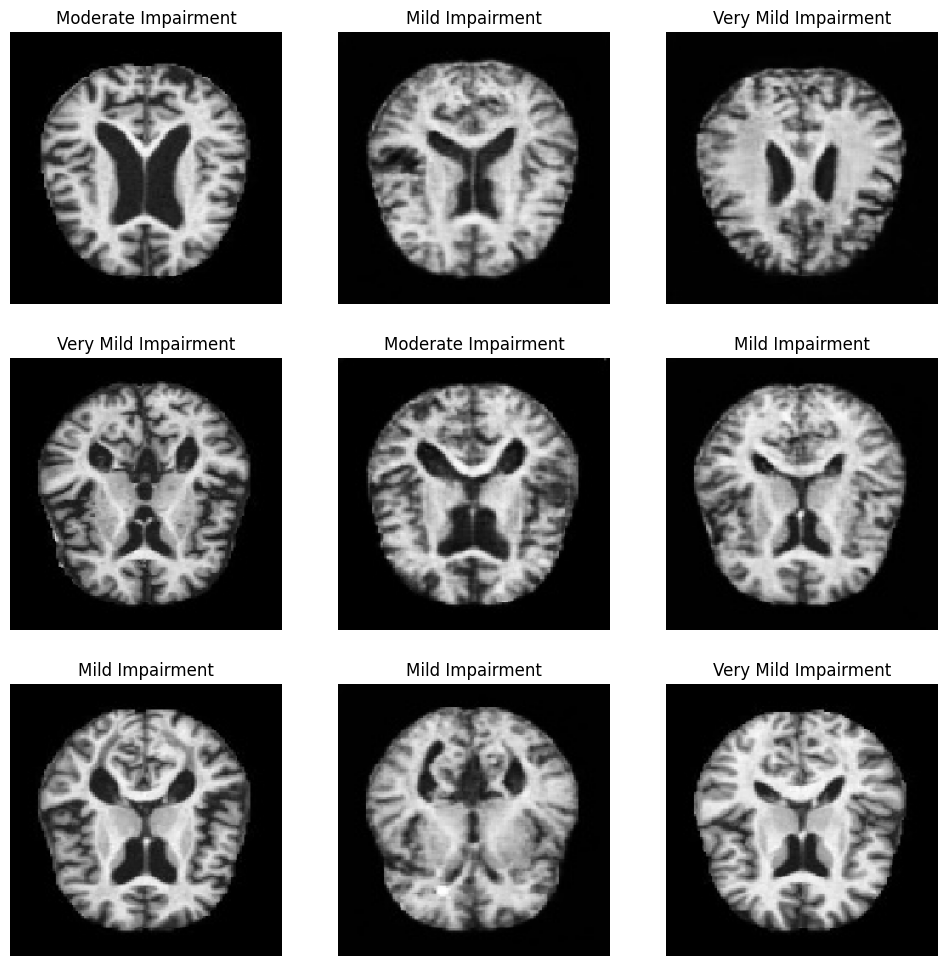

In [15]:
#Visualizing images of different classes
plt.figure(figsize=(12,12))

for images,labels in train_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        print(images[i].shape)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break

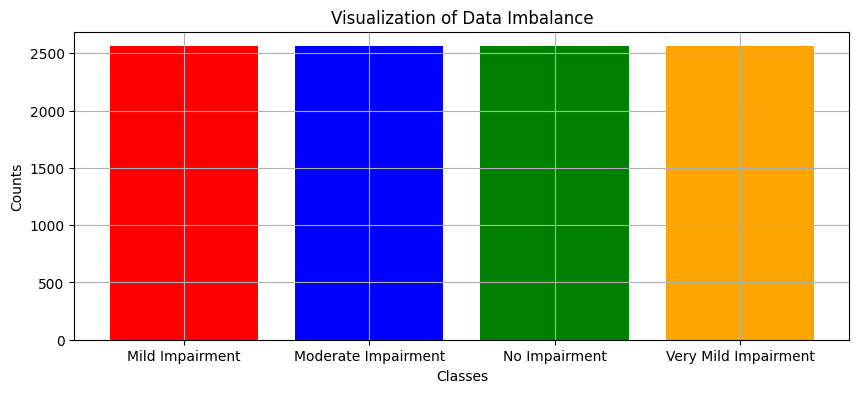

In [16]:
input_folder='/content/MRI_Dataset/Combined Dataset/train'

class_count=dict()

for i in class_names:
    class_count[i]=len(os.listdir(input_folder+'/'+i))

plt.figure(figsize=(10,4))
colors = ['red', 'blue', 'green', 'orange']
plt.bar(class_count.keys(),class_count.values(),color=colors)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Visualization of Data Imbalance')
plt.grid(True)
plt.show()

In [19]:
total_samples=sum(class_count.values())

for i in range(4):
    class_weight = round(total_samples / (4 * list(class_count.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weight}')

Weight for class "Mild Impairment" : 1.0
Weight for class "Moderate Impairment" : 1.0
Weight for class "No Impairment" : 1.0
Weight for class "Very Mild Impairment" : 1.0


In [17]:
def data_augmentar():
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    return data_augmentation

In [18]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

In [21]:
filepath = './Vgg_best_weights.keras'
earlystopping=EarlyStopping(monitor='val_accuracy',
                           mode='max',
                           patience=15,
                           verbose=1)

checkpoint=ModelCheckpoint(filepath,monitor = 'val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)

callback_list=[earlystopping,checkpoint]

In [25]:
input_shape = (224, 224, 3)

# Create an instance of the VGG16 model
vgg16 = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

# Freeze the layers of the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Define new layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')

# Create final model
model = tf.keras.Sequential([
    vgg16,
    global_average_layer,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    prediction_layer
])

# Compile Model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [26]:
from re import VERBOSE
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs= 20,
    verbose = 1
)


Epoch 1/20
 10/256 ━━━━━━━━━━━━━━━━━━━━ 1:21:12 20s/step - accuracy: 0.3772 - auc_1: 0.6618 - loss: 1.2300 - precision_1: 0.7148 - recall_1: 0.1524

KeyboardInterrupt: 